In [1]:
import modeller
import fitter

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

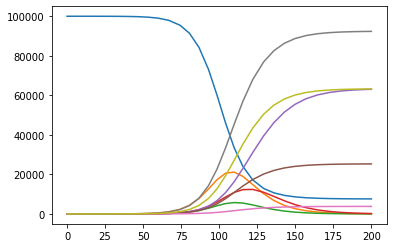

In [3]:
from scipy.integrate import solve_ivp

y0 = [1e5, 1, 0, 0, 0, 0, 0, 0, 0]
p_true = [1, 1/10, 1/4, 1/10, 1/10, 0.015]

sol = solve_ivp(lambda t,y: seir(t,y,p_true), [0, 200], y0, dense_output=True)
plt.plot(sol.t, sol.y.T)

In [4]:
import random
def sample(t, y, n=20):
    assert len(t) == len(y)
    return sorted(random.sample(list(zip(t, y)), n))

In [5]:
tfine = np.linspace(0, 150, 151)
yfine_pure = sol.sol(tfine).T
yfine = yfine_pure*(1 + 0.02*np.random.randn(*yfine_pure.shape))

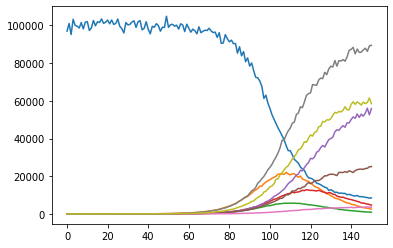

In [6]:
plt.plot(tfine, yfine);

In [7]:
data_time, data = zip(*sample(tfine, yfine))

In [8]:
data_time = np.array(data_time)
data_pd = np.vstack(data).astype(float)

In [9]:
print(data_time)

[  3.   4.  41.  48.  50.  51.  58.  70.  72.  79.  84.  87.  91.  94.
 103. 105. 113. 116. 127. 135.]


In [10]:
extract_data_vector = [3,4,6,7,8]
ex_data_pd = data_pd[:,extract_data_vector]

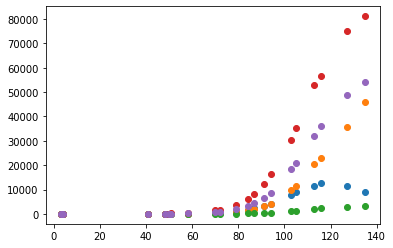

In [11]:
plt.plot(data_time, ex_data_pd, 'o');

In [12]:
p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.02]
model_form = {"state": 9, "parameters": 6}
config = {
    "grid_size": 200,
    "basis_number": 32,
    "model_form": model_form,
    "time_span": [0, 200],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": ex_data_pd, "t": data_time},
    "observation_vector": extract_data_vector,
    "weightings":[
        [1]*model_form['state'],
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [13]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [14]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(model_form['state'])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*model_form['state']) + [0]*len(config['regularisation_value'])
alpha = 1e1

In [15]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)

In [16]:
prange = np.logspace(-4, 6, num=41)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=0.0001

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6894
Number of nonzeros in Lagrangian Hessian.............:     5760

Total number of variables............................:      294
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0

In iteration 39, 1 Slack too small, adjusting variable bound
  40  2.3964946e+03 0.00e+00 2.55e-06  -8.6 2.13e+00    -  4.10e-01 9.87e-01f  1

Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   2.3964946272153493e+03    2.3964946272153493e+03
Dual infeasibility......:   7.8359386326486617e-10    7.8359386326486617e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.6066096998025091e-10    9.6066096998025091e-10
Overall NLP error.......:   9.6066096998025091e-10    9.6066096998025091e-10


Number of objective function evaluations             = 50
Number of objective gradient evaluations             = 45
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 50
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 45
Number of Lagrangian He


Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   3.3383931497373628e+03    3.3383931497373628e+03
Dual infeasibility......:   3.5752399888120225e-09    3.5752399888120225e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.5192372921487970e-09    5.5192372921487970e-09
Overall NLP error.......:   5.5192372921487970e-09    5.5192372921487970e-09


Number of objective function evaluations             = 53
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 53
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 47
Number of Lagrangian Hessian evaluations             = 46
Total CPU secs in IPOPT (w/o function evaluations)   =      0.248
Total CPU secs in NLP function evaluation

  30  7.6996986e+03 0.00e+00 1.35e+01  -2.5 1.70e+01    -  1.00e+00 1.00e+00f  1
  40  7.6988828e+03 0.00e+00 3.32e-01  -5.7 1.07e+02    -  8.48e-01 6.32e-01f  1
  50  7.6988736e+03 0.00e+00 2.22e-06  -8.6 1.94e-01    -  7.35e-01 7.88e-01f  1

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   7.6988735831390750e+03    7.6988735831390750e+03
Dual infeasibility......:   9.7328222873112146e-10    9.7328222873112146e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.9120938381975346e-09    3.9120938381975346e-09
Overall NLP error.......:   3.9120938381975346e-09    3.9120938381975346e-09


Number of objective function evaluations             = 58
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 58
Number of equality constraint Jacobia

  20  1.9502113e+04 0.00e+00 7.31e+01  -1.7 1.60e+05    -  3.69e-01 6.92e-02f  2
  30  1.9490341e+04 0.00e+00 8.10e-02  -3.8 1.36e+01    -  1.00e+00 1.00e+00f  1
  40  1.9490311e+04 0.00e+00 1.29e-04  -8.6 1.89e-01    -  8.55e-01 4.95e-01f  1

Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   1.9490310834863525e+04    1.9490310834863525e+04
Dual infeasibility......:   4.8851411547300883e-09    4.8851411547300883e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.9817969238673944e-09    3.9817969238673944e-09
Overall NLP error.......:   4.8851411547300883e-09    4.8851411547300883e-09


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 45
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality constraint Jacobia

Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8572973e+04 0.00e+00 8.40e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.7336482e+04 0.00e+00 6.34e+02  -1.0 4.08e+02    -  5.84e-01 1.00e+00f  1
  20  3.7312953e+04 0.00e+00 2.94e+01  -2.5 3.17e+01    -  1.00e+00 1.00e+00f  1
  30  3.7312225e+04 0.00e+00 6.89e-04  -5.7 9.20e-01    -  9.08e-01 7.76e-01f  1
In iteration 34, 1 Slack too small, adjusting variable bound
In iteration 37, 1 Slack too small, adjusting variable bound
  40  3.7312225e+04 0.00e+00 4.48e-10  -8.6 2.32e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   3.731

  30  8.7519227e+04 0.00e+00 7.38e-04  -8.6 3.87e-02    -  7.75e-01 4.14e-01f  1
In iteration 31, 1 Slack too small, adjusting variable bound

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   8.7519227347079039e+04    8.7519227347079039e+04
Dual infeasibility......:   3.4573516363238982e-09    3.4573516363238982e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.8191475492344166e-09    6.8191475492344166e-09
Overall NLP error.......:   6.8191475492344166e-09    6.8191475492344166e-09


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 36
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian He

  40  2.3487585e+05 0.00e+00 4.12e-09  -9.0 2.25e-10    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   2.3487584517862729e+05    2.3487584517862729e+05
Dual infeasibility......:   4.1161781769993092e-09    4.1161781769993092e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0922783198536253e-10    9.0922783198536253e-10
Overall NLP error.......:   4.1161781769993092e-09    4.1161781769993092e-09


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 43
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 41
Number of Lagrangian Hessian evaluations             = 40
Total CPU secs in IPOPT (w

  30  4.3806596e+05 0.00e+00 1.28e-04  -8.6 6.69e-04    -  9.25e-01 1.00e+00f  1
  40  4.3806596e+05 0.00e+00 1.36e-07  -9.0 1.05e-10    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   4.3806595876816777e+05    4.3806595876816777e+05
Dual infeasibility......:   1.5988526464239173e-07    1.5988526464239173e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1125065881671552e-10    9.1125065881671552e-10
Overall NLP error.......:   1.5988526464239173e-07    1.5988526464239173e-07


Number of objective function evaluations             = 53
Number of objective gradient evaluations             = 46
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 53
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 46
Num

  20  5.9856536e+05 0.00e+00 5.42e-02  -5.7 7.58e-02    -  8.98e-01 4.37e-01f  1
  30  5.9856536e+05 0.00e+00 3.73e-03  -8.6 7.73e-04    -  5.68e-01 9.39e-01f  1
  40  5.9856536e+05 0.00e+00 9.77e-07  -8.6 4.01e-10    -  1.00e+00 5.00e-01h  2
  50  5.9856536e+05 0.00e+00 2.05e-07  -8.6 1.51e-10    -  1.00e+00 2.50e-01h  3
  60  5.9856536e+05 0.00e+00 1.07e-06  -8.6 5.87e-11    -  1.00e+00 5.00e-01h  2
  70  5.9856536e+05 0.00e+00 2.25e-06  -8.6 9.31e-11    -  1.00e+00 1.00e+00w  1
  80  5.9856536e+05 0.00e+00 8.47e-07  -8.6 2.24e-10    -  1.00e+00 2.50e-01h  3
  90  5.9856536e+05 0.00e+00 1.07e-06  -8.6 9.20e-11    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.9856536e+05 0.00e+00 3.01e-07  -8.6 1.09e-10    -  1.00e+00 6.25e-02h  5
 110  5.9856536e+05 0.00e+00 8.40e-07  -8.6 7.27e-11    -  1.00e+00 1.25e-01h  4
 120  5.9856536e+05 0.00e+00 7.19e-07  -8.6 2.18e-10    -  1.00e+00 6.25e-02h  5
 130  5.9856536e+05 0.00e+00

In iteration 289, 1 Slack too small, adjusting variable bound
 290  6.5924965e+05 0.00e+00 3.71e+07  -8.6 9.62e+01  -3.3 1.63e-03 5.28e-03f  1
In iteration 290, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
In iteration 291, 1 Slack too small, adjusting variable bound
In iteration 292, 1 Slack too small, adjusting variable bound
In iteration 293, 1 Slack too small, adjusting variable bound
In iteration 298, 1 Slack too small, adjusting variable bound
 300  6.1870177e+05 0.00e+00 7.76e+06  -8.6 5.60e+01  -4.4 1.76e-01 1.26e-01f  1
In iteration 306, 1 Slack too small, adjusting variable bound
In iteration 307, 1 Slack too small, adjusting variable bound
 310  6.1682833e+05 0.00e+00 1.25e+06  -8.6 1.90e+01    -  4.79e-01 4.51e-01f  1
In iteration 310, 1 Slack too small, adjusting variable bound
In iteration 314, 1 Slack too small, adjusting variable bound
In iteration 316, 1 Slack too small, adjusting variable 

 410r 7.8043981e+05 0.00e+00 1.18e-02  -8.6 1.94e-02    -  7.42e-01 1.00e+00h  1
 420r 7.8040842e+05 0.00e+00 8.37e-06  -8.6 1.31e+00    -  5.62e-01 1.00e+00h  1
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 425

                                   (scaled)                 (unscaled)
Objective...............:   6.3275536589063494e+05    6.3275536589063494e+05
Dual infeasibility......:   6.4019586650076685e+06    6.4019586650076685e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.2428824129733934e-11    5.2428824129733934e-11
Overall NLP error.......:   6.4019586650076685e+06    6.4019586650076685e+06


Number of objective function evaluations             = 1478
Number of objective gradient evaluations             = 399
Number of equality constraint evaluations            = 0
Number of in

In iteration 140, 1 Slack too small, adjusting variable bound
In iteration 141, 1 Slack too small, adjusting variable bound
In iteration 143, 1 Slack too small, adjusting variable bound
In iteration 145, 1 Slack too small, adjusting variable bound
In iteration 147, 1 Slack too small, adjusting variable bound
In iteration 148, 1 Slack too small, adjusting variable bound
In iteration 149, 1 Slack too small, adjusting variable bound
 150  6.9094450e+05 0.00e+00 7.06e+07  -8.6 4.17e+01  -3.0 2.05e-03 1.55e-03f  1
In iteration 150, 1 Slack too small, adjusting variable bound
In iteration 151, 1 Slack too small, adjusting variable bound
In iteration 152, 1 Slack too small, adjusting variable bound
In iteration 153, 1 Slack too small, adjusting variable bound
In iteration 154, 1 Slack too small, adjusting variable bound
In iteration 156, 1 Slack too small, adjusting variable bound
In iteration 157, 1 Slack too small, adjusting variable bound
In iteration 158, 1 Slack too small, adjusting vari

  40  7.1099916e+05 0.00e+00 2.84e-01  -3.8 9.81e+00  -8.0 1.00e+00 1.00e+00f  1
  50  7.0693507e+05 0.00e+00 5.22e+00  -3.8 3.34e+03    -  1.00e+00 2.50e-01f  3
  60  6.9521129e+05 0.00e+00 2.05e-01  -5.7 4.16e+02 -11.8 1.00e+00 1.00e+00h  1
  70  6.9471401e+05 0.00e+00 6.52e-02  -5.7 8.31e+02 -12.1 1.00e+00 1.00e+00f  1
  80  6.9356470e+05 0.00e+00 5.48e-01  -5.7 1.74e+03 -12.4 1.00e+00 1.00e+00f  1
  90  6.9297652e+05 0.00e+00 1.50e-02  -8.6 1.85e+01    -  1.00e+00 6.82e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.9297489e+05 0.00e+00 7.95e-07 -10.6 1.68e-03    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 101

                                   (scaled)                 (unscaled)
Objective...............:   1.8357329303709822e+00    6.9297489318885922e+05
Dual infeasibility......:   1.1202790500287145e-10    4.2289662193861608e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  30  1.8528454e+06 0.00e+00 6.71e+02  -2.5 8.61e+03    -  9.82e-01 5.00e-01f  2
  40  1.0279299e+06 0.00e+00 3.45e+01  -3.8 4.81e+03    -  1.00e+00 1.25e-01f  4
  50  9.2305194e+05 0.00e+00 2.14e+02  -3.8 5.02e+03    -  1.00e+00 1.25e-01f  4
  60  8.8496044e+05 0.00e+00 2.24e+00  -3.8 1.25e+01  -8.3 1.00e+00 1.00e+00f  1
  70  8.6726342e+05 0.00e+00 8.89e-01  -3.8 2.81e+01  -9.0 1.00e+00 1.00e+00f  1
  80  8.6038738e+05 0.00e+00 5.72e+00  -3.8 6.38e+01    -  1.00e+00 1.00e+00h  1
  90  8.1485031e+05 0.00e+00 1.69e-01  -5.7 4.20e+00  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.1455735e+05 0.00e+00 3.15e-01  -5.7 2.46e+03 -13.0 1.00e+00 1.00e+00f  1
 110  8.1330182e+05 0.00e+00 5.29e-01  -5.7 5.00e+03 -13.3 1.00e+00 1.00e+00f  1
 120  8.1187302e+05 0.00e+00 4.92e+00  -5.7 1.37e+03 -12.6 1.00e+00 5.00e-01h  2
 130  8.1114276e+05 0.00e+00 2.35e+00  -8.6 2.19e+03    -  9.72e-01 6.17e-01f  1
 140  8.1095350e+05 0.00e+00

 170  1.1469059e+06 0.00e+00 1.16e-06 -11.8 1.39e-01    -  8.23e-01 5.40e-01f  1

Number of Iterations....: 175

                                   (scaled)                 (unscaled)
Objective...............:   1.8697150637308202e-01    1.1469058902600601e+06
Dual infeasibility......:   1.8176797568524726e-10    1.1149868020963363e-03
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2429044496141917e-11    7.6241265952499190e-05
Overall NLP error.......:   1.8176797568524726e-10    1.1149868020963363e-03


Number of objective function evaluations             = 361
Number of objective gradient evaluations             = 176
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 361
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 176
Number of Lagrangian Hessian evaluations             = 175
Total CPU secs in IP

  90  2.1034777e+07 0.00e+00 2.99e+00  -2.5 4.17e+01  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1486155e+07 0.00e+00 3.31e+00  -2.5 4.58e+01 -10.3 1.00e+00 1.00e+00f  1
 110  2.1697031e+07 0.00e+00 3.29e-05  -2.5 1.62e-01    -  1.00e+00 1.00e+00h  1
 120  7.2690007e+06 0.00e+00 1.00e+02  -3.8 2.14e+02  -8.8 1.00e+00 1.00e+00f  1
 130  6.1405799e+06 0.00e+00 3.52e+00  -3.8 1.10e+02  -9.0 1.00e+00 1.00e+00f  1
 140  5.3808680e+06 0.00e+00 5.30e+00  -3.8 1.43e+02  -9.2 1.00e+00 1.00e+00f  1
 150  4.7869082e+06 0.00e+00 5.35e+00  -3.8 8.51e+01  -9.0 1.00e+00 1.00e+00f  1
 160  4.1877806e+06 0.00e+00 1.02e+02  -3.8 1.82e+02  -9.2 1.00e+00 1.00e+00f  1
 170  3.8627857e+06 0.00e+00 3.60e+01  -3.8 2.61e+03 -10.3 1.00e+00 6.25e-02f  5
 180  3.5179489e+06 0.00e+00 2.25e+01  -3.8 4.13e+02 -10.1 1.00e+00 5.00e-01f  2
 190  3.2639683e+06 0.00e+00 3.23e+01  -3.8 2.52e+02 -10.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 470  2.9503653e+06 0.00e+00 3.64e-04  -5.7 1.14e-10    -  1.00e+00 1.00e+00h  1
 480  2.9503653e+06 0.00e+00 4.27e-04  -5.7 6.83e-11    -  1.00e+00 1.00e+00h  1
 490  2.9503653e+06 0.00e+00 1.56e-03  -5.7 2.06e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.9503653e+06 0.00e+00 4.41e-04  -5.7 1.22e-10    -  1.00e+00 1.00e+00h  1
 510  2.9503653e+06 0.00e+00 7.29e-04  -5.7 2.10e-10    -  1.00e+00 1.00e+00H  1
Restoration phase is called at point that is almost feasible,
  with constraint violation 6.651334e-12. Abort.

Number of Iterations....: 511

                                   (scaled)                 (unscaled)
Objective...............:   1.7343814991348954e+06    2.9503653133572955e+06
Dual infeasibility......:   7.0280587238770887e-04    1.1955466942831108e-03
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144759999395e-06    3.1383935303830

In [17]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

(0.1, 100000000.0)

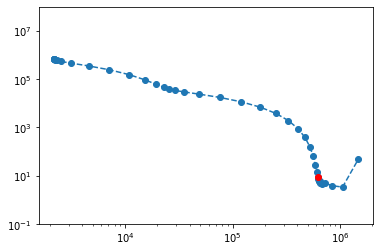

In [26]:
idx = 30
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')
plt.ylim(1e-1, 1e8)

(0.0001, 10.0)

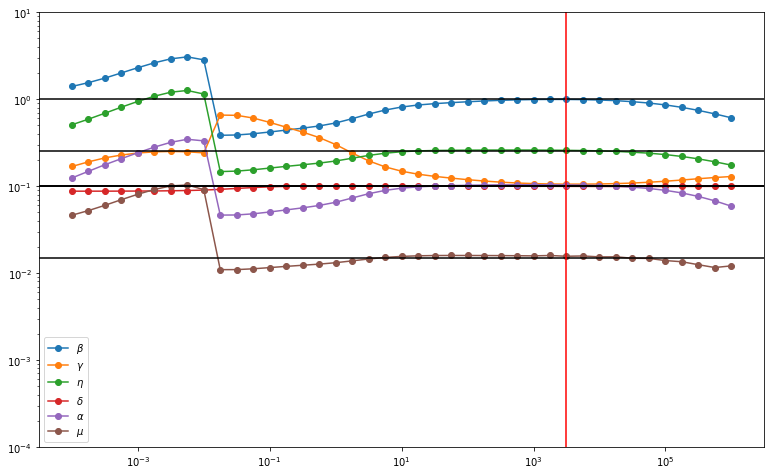

In [27]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p_true:
    plt.axhline(q, color='k')
# plt.axhline(0.125, color='k', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.ylim([1e-4, 1e1])

(DM(0.990757), DM(0.105245), DM(0.257682), DM(0.0992177), DM(0.102953), DM(0.0155927))
[1, 0.1, 0.25, 0.1, 0.1, 0.015]


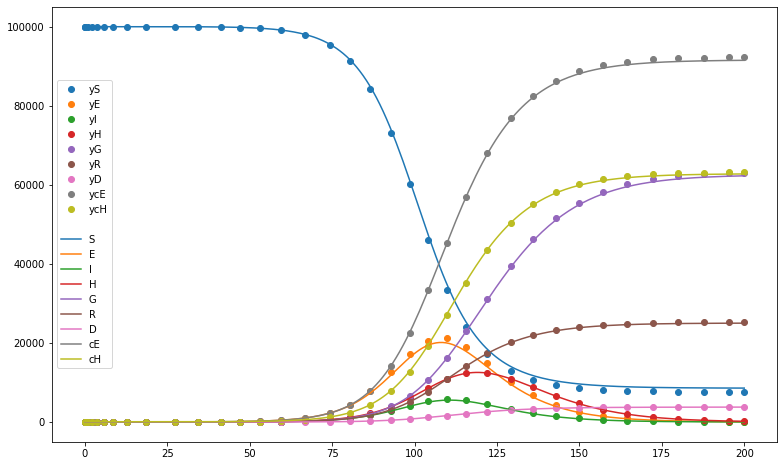

In [28]:
fig, ax=plt.subplots(figsize=[13, 8])
ax.plot(sol.t, sol.y.T, 'o')
ax.plot(0,0, marker="None", linestyle="None")
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yS', 'yE', 'yI', 'yH', 'yG', 'yR', 'yD', 'ycE', 'ycH', '', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
print(getp(sols[idx]['x']))
print(p_true)

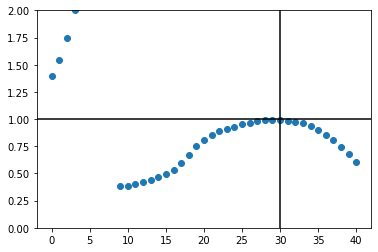

In [31]:
def getbSN(sol):
    b, g, e, d, a, m = list(map(float, getp(sol['x'])))
    S,E,I,H,G,R,D,cE,cH = list(map(lambda x: float(x[0]), getx(sol['x'])))
    return b*(S/(S+R))
    
plt.plot([getbSN(s) for s in sols], 'o')
plt.ylim([0, 2])
plt.axhline(1, color='k')
plt.axvline(idx, color='k')

(DM(0.990757), DM(0.105245), DM(0.257682), DM(0.0992177), DM(0.102953), DM(0.0155927))
[1, 0.1, 0.25, 0.1, 0.1, 0.015]


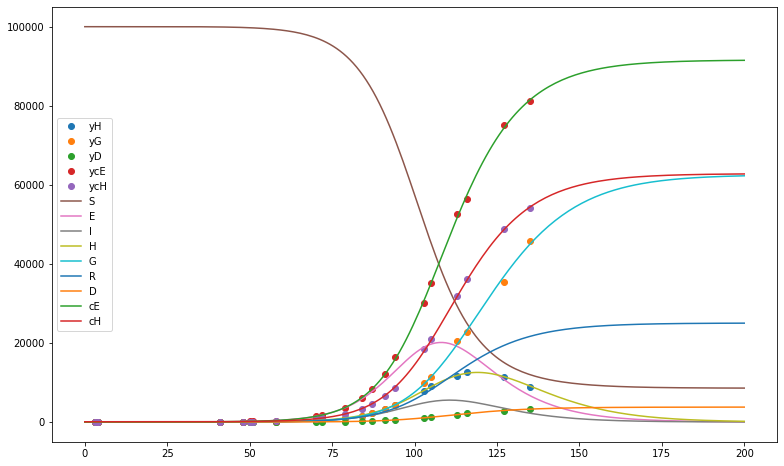

In [30]:
fig, ax=plt.subplots(figsize=[13, 8])
ax.plot(data_time, ex_data_pd, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
print(getp(sols[idx]['x']))
print(p_true)